In [ ]:
###
import sys
print(sys.path)
sys.path.append("C:/Users/jz421/Desktop/GlobalLocal/IEEG_Pipelines/") #need to do this cuz otherwise ieeg isn't added to path...

from ieeg.navigate import channel_outlier_marker, trial_ieeg, crop_empty_data, \
    outliers_to_nan
from ieeg.io import raw_from_layout, get_data
from ieeg.timefreq.utils import crop_pad
from ieeg.timefreq import gamma
from ieeg.calc.scaling import rescale
import mne
import os
import numpy as np
from ieeg.calc.reshape import make_data_same
from ieeg.calc.stats import time_perm_cluster

from misc_functions import calculate_RTs, save_channels_to_file, save_sig_chans
import matplotlib.pyplot as plt


def get_baseline(inst: mne.io.BaseRaw, base_times: tuple[float, float]):
    inst = inst.copy()
    inst.load_data()
    ch_type = inst.get_channel_types(only_data_chs=True)[0]
    inst.set_eeg_reference(ref_channels="average", ch_type=ch_type)

    adjusted_base_times = [base_times[0] - 0.5, base_times[1] + 0.5]
    trials = trial_ieeg(inst, "experimentStart", adjusted_base_times,
                        preload=True)
    # outliers_to_nan(trials, outliers=10)
    HG_base = gamma.extract(trials, copy=False, n_jobs=1)
    crop_pad(HG_base, "0.5s")
    del inst
    return HG_base


def plot_HG_and_stats(sub, task, output_name, event=None, times=(-1, 1.5),
                      base_times=(-0.5, 0), LAB_root=None, channels=None,
                      full_trial_base=False):
    """
    Plot high gamma (HG) and statistics for a given subject and task using specified event.

    Parameters:
    - sub (str): The subject identifier.
    - task (str): The task identifier.
    - output_name (str): The name for the output files.
    - event (str, optional): Event name to process. Defaults to None.
    - times (tuple, optional): A tuple indicating the start and end times for processing. Defaults to (-1, 1.5).
    - base_times (tuple, optional): A tuple indicating the start and end base times for processing. Defaults to (-0.5, 0).
    - LAB_root (str, optional): The root directory for the lab. Will be determined based on OS if not provided. Defaults to None.
    - channels (list of strings, optional): The channels to plot and get stats for. Default is all channels.
    - full_trial_base (boolean): Whether to use the full trial as the baseline period. Default is False.
    This function will process the provided event for a given subject and task.
    High gamma (HG) will be computed, and statistics will be calculated and plotted.
    The results will be saved to output files.
    """
    pass


sub = 'D0057'
task = 'GlobalLocal'
output_name = "driftTest_Stimulus_experimentStartBaseNormalizedAnd0.5SecBeforeEventTrialsonXAxis"
events = ["Stimulus"]
times = (-0.5,0)
base_times = (1, 101)
LAB_root = None
channels = None
full_trial_base = False

if LAB_root is None:
    HOME = os.path.expanduser("~")
    if os.name == 'nt':  # windows
        LAB_root = os.path.join(HOME, "Box", "CoganLab")
    else:  # mac
        LAB_root = os.path.join(HOME, "Library", "CloudStorage", "Box-Box",
                                "CoganLab")

layout = get_data(task, root=LAB_root)
filt = raw_from_layout(layout.derivatives['derivatives/clean'], subject=sub,
                       extension='.edf', desc='clean', preload=False)
save_dir = os.path.join(layout.root, 'derivatives', 'freqFilt', 'figs', sub)
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

###

good = crop_empty_data(filt)
# %%

print(f"good channels before dropping bads: {len(good.ch_names)}")
print(f"filt channels before dropping bads: {len(filt.ch_names)}")

good.info['bads'] = channel_outlier_marker(good, 3, 2)
print("Bad channels in 'good':", good.info['bads'])

filt.drop_channels(good.info['bads'])  # this has to come first cuz if you drop from good first, then good.info['bads'] is just empty
good.drop_channels(good.info['bads'])

print("Bad channels in 'good' after dropping once:", good.info['bads'])

print(f"good channels after dropping bads: {len(good.ch_names)}")
print(f"filt channels after dropping bads: {len(filt.ch_names)}")

HG_base = get_baseline(filt, base_times)
good.load_data()

# If channels is None, use all channels
if channels is None:
    channels = good.ch_names
else:
    # Validate the provided channels
    invalid_channels = [ch for ch in channels if ch not in good.ch_names]
    if invalid_channels:
        raise ValueError(
            f"The following channels are not valid: {invalid_channels}")

    # Use only the specified channels
    good.pick_channels(channels)

ch_type = filt.get_channel_types(only_data_chs=True)[0]
good.set_eeg_reference(ref_channels="average", ch_type=ch_type)

all_epochs_list = []

for event in events:
# Epoching and HG extraction for each specified event. Then concatenate all trials epochs objects together (do Stimulus/c25 and Stimulus/c75 for example, and combine to get all congruent trials)
    times_adj = [times[0] - 0.5, times[1] + 0.5]
    trials = trial_ieeg(good, event, times_adj, preload=True,
                        reject_by_annotation=False)
    all_epochs_list.append(trials)

# Concatenate all trials
all_trials = mne.concatenate_epochs(all_epochs_list)

outliers_to_nan(all_trials, outliers=10)
HG_ev1 = gamma.extract(all_trials, copy=False, n_jobs=1)
crop_pad(HG_ev1, "0.5s")
HG_ev1_rescaled = rescale(HG_ev1, HG_base, copy=True, mode='zscore')

HG_base.decimate(2)
HG_ev1.decimate(2)


HG_ev1_avgOverTime = np.nanmean(HG_ev1.get_data(), axis=2)
HG_ev1_rescaled_avgOverTime = np.nanmean(HG_ev1_rescaled.get_data(), axis=2)


# HG_ev1_evoke = HG_ev1.average(method=lambda x: np.nanmean(x, axis=0)) #axis=0 should be set for actually running this, the axis=2 is just for drift testing.
# HG_ev1_evoke_rescaled = HG_ev1_rescaled.average(method=lambda x: np.nanmean(x, axis=0))

['c:\\Users\\jz421\\Desktop\\GlobalLocal', 'C:\\Users\\jz421\\Desktop\\GlobalLocal\\IEEG_Pipelines', 'c:\\Users\\jz421\\AppData\\Local\\anaconda3\\envs\\ieeg\\python311.zip', 'c:\\Users\\jz421\\AppData\\Local\\anaconda3\\envs\\ieeg\\DLLs', 'c:\\Users\\jz421\\AppData\\Local\\anaconda3\\envs\\ieeg\\Lib', 'c:\\Users\\jz421\\AppData\\Local\\anaconda3\\envs\\ieeg', '', 'C:\\Users\\jz421\\AppData\\Roaming\\Python\\Python311\\site-packages', 'C:\\Users\\jz421\\AppData\\Roaming\\Python\\Python311\\site-packages\\win32', 'C:\\Users\\jz421\\AppData\\Roaming\\Python\\Python311\\site-packages\\win32\\lib', 'C:\\Users\\jz421\\AppData\\Roaming\\Python\\Python311\\site-packages\\Pythonwin', 'c:\\Users\\jz421\\AppData\\Local\\anaconda3\\envs\\ieeg\\Lib\\site-packages', 'c:\\Users\\jz421\\AppData\\Local\\anaconda3\\envs\\ieeg\\Lib\\site-packages\\win32', 'c:\\Users\\jz421\\AppData\\Local\\anaconda3\\envs\\ieeg\\Lib\\site-packages\\win32\\lib', 'c:\\Users\\jz421\\AppData\\Local\\anaconda3\\envs\\ieeg\\L

C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (179) does not match the number of channels in the raw data file (178). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0057\ieeg\sub-D0057_task-GlobalLocal_acq-01_run-02_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0057\ieeg\sub-D0057_task-GlobalLocal_acq-01_run-02_desc-clean_channels.tsv.
Reading electrode coords from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0057\ieeg\sub-D0057_acq-01_space-ACPC_electrodes.tsv.
Extracting EDF parameters from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0057\ieeg\sub-D0057_task-GlobalLocal_acq-01_run-03_desc-clean_ieeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Omitted 228 annotation(s) that were outside data range.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (179) does not match the number of channels in the raw data file (178). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0057\ieeg\sub-D0057_task-GlobalLocal_acq-01_run-03_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0057\ieeg\sub-D0057_task-GlobalLocal_acq-01_run-03_desc-clean_channels.tsv.
Reading electrode coords from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0057\ieeg\sub-D0057_acq-01_space-ACPC_electrodes.tsv.
Extracting EDF parameters from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0057\ieeg\sub-D0057_task-GlobalLocal_acq-01_run-04_desc-clean_ieeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Omitted 228 annotation(s) that were outside data range.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (179) does not match the number of channels in the raw data file (178). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0057\ieeg\sub-D0057_task-GlobalLocal_acq-01_run-04_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0057\ieeg\sub-D0057_task-GlobalLocal_acq-01_run-04_desc-clean_channels.tsv.
Reading electrode coords from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0057\ieeg\sub-D0057_acq-01_space-ACPC_electrodes.tsv.


C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Omitted 226 annotation(s) that were outside data range.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (179) does not match the number of channels in the raw data file (178). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


good channels before dropping bads: 178
filt channels before dropping bads: 178
outlier round 1 channels: ['RAMT8']
outlier round 2 channels: ['RAMT8', 'RPI16']
outlier round 2 channels: ['RAMT8', 'RPI16', 'LAMT12']
Bad channels in 'good': ['RAMT8', 'RPI16', 'LAMT12']
Bad channels in 'good' after dropping once: []
good channels after dropping bads: 175
filt channels after dropping bads: 175
Reading 0 ... 8243199  =      0.000 ...  4025.000 secs...
Applying average reference.
Applying a custom ('sEEG',) reference.
Used Annotations descriptions: ['Response/c25/n25', 'Response/c25/r25', 'Response/c25/r75', 'Response/c25/s25', 'Response/c25/s75', 'Response/c75/r25', 'Response/c75/r75', 'Response/c75/s25', 'Response/c75/s75', 'Response/i25/r25', 'Response/i25/r75', 'Response/i25/s25', 'Response/i25/s75', 'Response/i75/n25', 'Response/i75/n75', 'Response/i75/r25', 'Response/i75/r75', 'Response/i75/s25', 'Response/i75/s75', 'Stimulus/c25/n25', 'Stimulus/c25/r25', 'Stimulus/c25/r75', 'Stimulus

100%|██████████| 1/1 [01:00<00:00, 60.50s/it]


Reading 0 ... 5983997  =      0.000 ...  2921.874 secs...
Applying average reference.
Applying a custom ('sEEG',) reference.
Used Annotations descriptions: ['Response/c25/n25', 'Response/c25/r25', 'Response/c25/r75', 'Response/c25/s25', 'Response/c25/s75', 'Response/c75/r25', 'Response/c75/r75', 'Response/c75/s25', 'Response/c75/s75', 'Response/i25/r25', 'Response/i25/r75', 'Response/i25/s25', 'Response/i25/s75', 'Response/i75/n25', 'Response/i75/n75', 'Response/i75/r25', 'Response/i75/r75', 'Response/i75/s25', 'Response/i75/s75', 'Stimulus/c25/n25', 'Stimulus/c25/r25', 'Stimulus/c25/r75', 'Stimulus/c25/s25', 'Stimulus/c25/s75', 'Stimulus/c75/r25', 'Stimulus/c75/r75', 'Stimulus/c75/s25', 'Stimulus/c75/s75', 'Stimulus/i25/n75', 'Stimulus/i25/r25', 'Stimulus/i25/r75', 'Stimulus/i25/s25', 'Stimulus/i25/s75', 'Stimulus/i75/n25', 'Stimulus/i75/n75', 'Stimulus/i75/r25', 'Stimulus/i75/r75', 'Stimulus/i75/s25', 'Stimulus/i75/s75', 'experimentStart']
Not setting metadata
448 matching events fou

C:\Users\jz421\AppData\Local\Temp\ipykernel_6600\3559917926.py:134: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  all_trials = mne.concatenate_epochs(all_epochs_list)


Not setting metadata
448 matching events found
No baseline correction applied


100%|██████████| 448/448 [04:53<00:00,  1.53it/s]


Applying baseline correction (mode: zscore)


C:\Users\jz421\AppData\Local\Temp\ipykernel_6600\3559917926.py:141: RuntimeWarning: The measurement information indicates a low-pass frequency of 1024.0 Hz. The decim=2 parameter will result in a sampling frequency of 1024.0 Hz, which can cause aliasing artifacts.
  HG_base.decimate(2)
C:\Users\jz421\AppData\Local\Temp\ipykernel_6600\3559917926.py:142: RuntimeWarning: The measurement information indicates a low-pass frequency of 1024.0 Hz. The decim=2 parameter will result in a sampling frequency of 1024.0 Hz, which can cause aliasing artifacts.
  HG_ev1.decimate(2)
C:\Users\jz421\AppData\Local\Temp\ipykernel_6600\3559917926.py:145: RuntimeWarning: Mean of empty slice
  HG_ev1_avgOverTime = np.nanmean(HG_ev1.get_data(), axis=2)
C:\Users\jz421\AppData\Local\Temp\ipykernel_6600\3559917926.py:146: RuntimeWarning: Mean of empty slice
  HG_ev1_rescaled_avgOverTime = np.nanmean(HG_ev1_rescaled.get_data(), axis=2)


In [ ]:
HG_base.plot()

Using qt as 2D backend.


In [ ]:
HG_ev1_avgOverChannelsAndTime = np.nanmean(np.nanmean(HG_ev1.get_data(), axis=2), axis=1)
HG_ev1_rescaled_avgOverChannelsAndTime = np.nanmean(np.nanmean(HG_ev1_rescaled.get_data(), axis=2), axis=1)


C:\Users\jz421\AppData\Local\Temp\ipykernel_6600\445732840.py:1: RuntimeWarning: Mean of empty slice
  HG_ev1_avgOverChannelsAndTime = np.nanmean(np.nanmean(HG_ev1.get_data(), axis=2), axis=1)
C:\Users\jz421\AppData\Local\Temp\ipykernel_6600\445732840.py:2: RuntimeWarning: Mean of empty slice
  HG_ev1_rescaled_avgOverChannelsAndTime = np.nanmean(np.nanmean(HG_ev1_rescaled.get_data(), axis=2), axis=1)


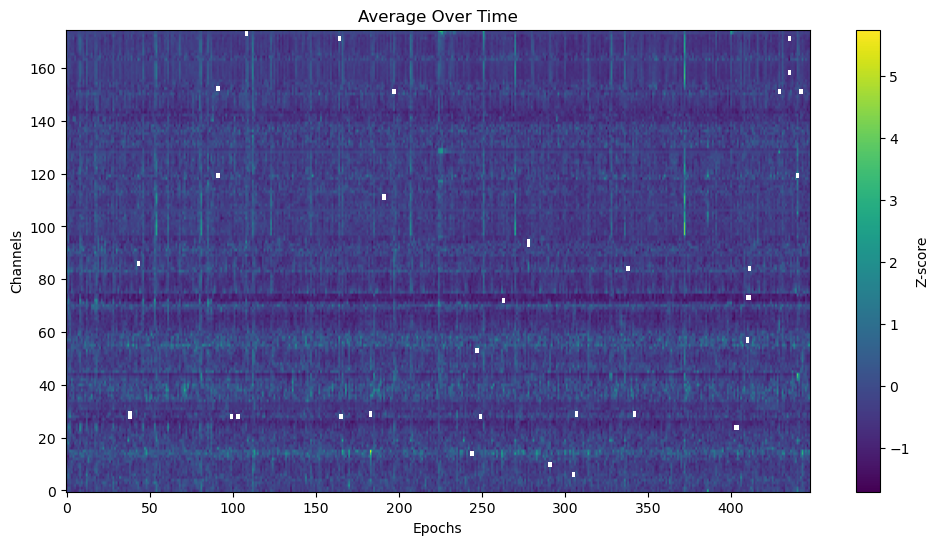

In [ ]:
# Plotting
plt.figure(figsize=(12, 6))
plt.imshow(HG_ev1_rescaled_avgOverTime.T, aspect='auto', cmap='viridis', origin='lower')
plt.colorbar(label='Z-score')
plt.xlabel('Epochs')
plt.ylabel('Channels')
plt.title('Average Over Time')
plt.show()

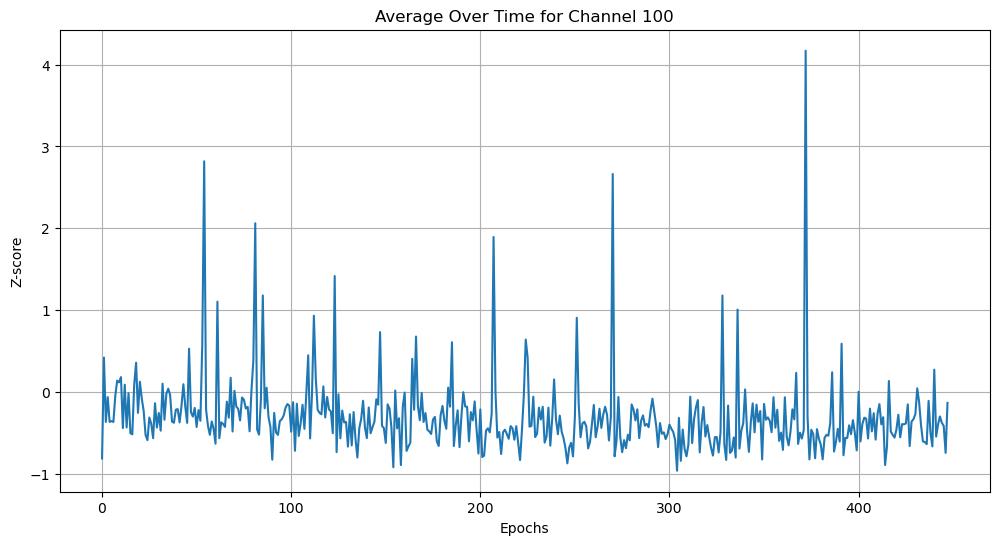

In [ ]:
# Let's plot the data for a single channel. For demonstration purposes, we'll choose the first channel (index 0).
channel_idx = 100
channel_data = HG_ev1_rescaled_avgOverTime[:, channel_idx]

plt.figure(figsize=(12, 6))
plt.plot(channel_data)
plt.xlabel('Epochs')
plt.ylabel('Z-score')
plt.title('Average Over Time for Channel {}'.format(channel_idx))
plt.grid(True)
plt.show()


In [ ]:
HG_ev1_rescaled_avgOverChannelsAndTime.shape

(448,)

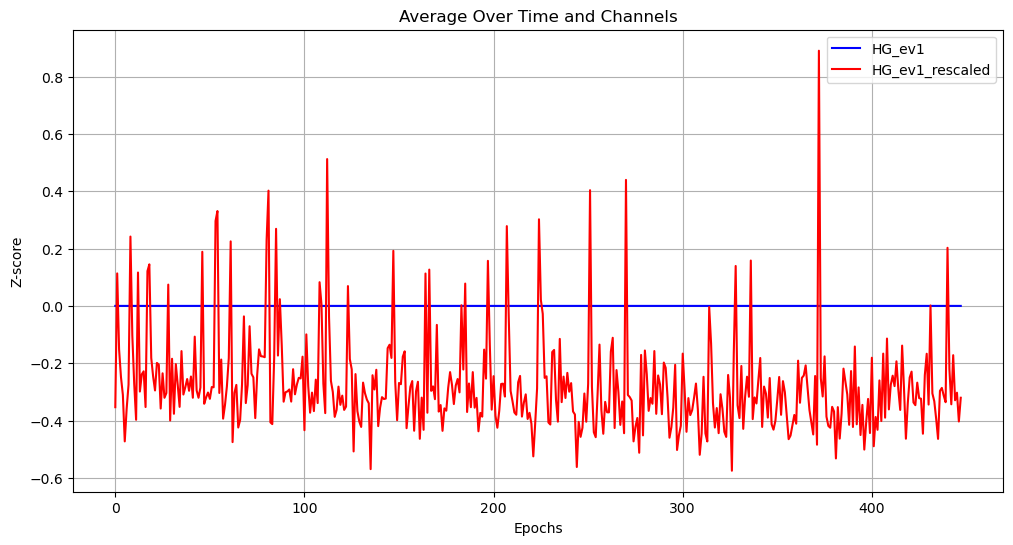

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(HG_ev1_avgOverChannelsAndTime, label='HG_ev1', color='blue')
plt.plot(HG_ev1_rescaled_avgOverChannelsAndTime, label='HG_ev1_rescaled', color='red')
plt.xlabel('Epochs')
plt.ylabel('Z-score')
plt.title('Average Over Time and Channels')
plt.legend()
plt.grid(True)
plt.show()